In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import chi2
import itertools

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## ARCH model

***ARCH stands for Autoregressive Conditional Heteroscedasticity.***

***ARCH(q) only has one order, q. It is the number of previous values(lags) we should include in our model.***

* *We want stability in our forecasts, meaning that it should not be volatile. Only under big shocks, should the model perform bad. For this, we square the values in our time series.*

* *The "conditional" part in ARCH stems from conditional probability, where we find variance of the current value given the variances of the past values.*

$$ARCH(1): \sigma^2_t = \alpha_0 + \alpha_1 \epsilon^2_t$$

$$ARCH(q): \sigma^2_t = \alpha_0 + \alpha_1 \epsilon^2_t + \alpha_2 \epsilon^2_{t-1} + \dotso + \alpha_q \epsilon^2_{t-q}$$

***We use the 2-equation ARCH which goes like this:***

$$X_t = C + \delta_1 \mu_{t-1} + \epsilon_t$$
$$\sigma^2 = \alpha_0 + \alpha_1 \epsilon^2_{t-1}$$

***We first estimate the residuals using the mean time series model, then we estimate the variance.***

***While we couldn't estimate no. of lags required for ARMA and ARIMA model using ACF/PACF plots, we can estimate no. of lags for ARCH models using PACF plots(for returns and squared returns).***

In [2]:
actual_data = pd.read_csv("../../datasets/stock_prices/index_2018.csv")
df = actual_data.copy()
df.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


In [3]:
df["date"] = pd.to_datetime(df["date"], dayfirst=True)
df_index = df["date"]
df.drop("date", axis=1, inplace=True)
df.index = df_index
df.index.name = None

df = df.asfreq("b")

df = df.apply(lambda x: x.fillna(method="ffill"))

df_spx = pd.DataFrame(df["spx"])
df_ftse = pd.DataFrame(df["ftse"])

df_ftse["returns"] = df_ftse["ftse"].pct_change(1)

In [4]:
df_ftse["sq_returns"] = df_ftse["returns"] ** 2

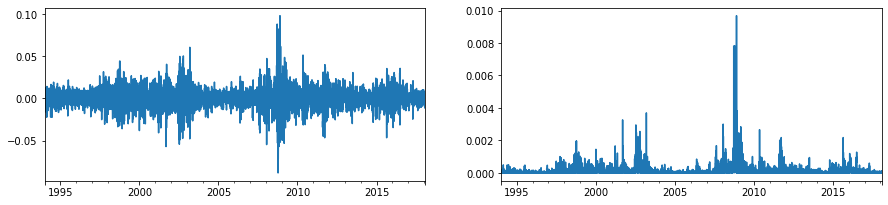

In [5]:
plt.figure(figsize=(15, 7))
layout = (2, 2)
returns_ax = plt.subplot2grid(layout, (0, 0))
sq_returns_ax = plt.subplot2grid(layout, (0, 1))
df_ftse["returns"].plot(ax=returns_ax)
df_ftse["sq_returns"].plot(ax=sq_returns_ax)
plt.show()

In [6]:
from arch import arch_model

In [7]:
model = arch_model(df_ftse["returns"][1:])
result = model.fit()
print(result.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: -20476.120460450245
Iteration:      2,   Func. Count:     21,   Neg. LLF: -20479.09420266111
Iteration:      3,   Func. Count:     37,   Neg. LLF: -19009.792202230885
Iteration:      4,   Func. Count:     53,   Neg. LLF: -2332.99496186534
Iteration:      5,   Func. Count:     66,   Neg. LLF: -16374.688590812915
Iteration:      6,   Func. Count:     82,   Neg. LLF: 1434.523924632803
Iteration:      7,   Func. Count:     96,   Neg. LLF: -6399.089322241207
Iteration:      8,   Func. Count:    110,   Neg. LLF: -11709.564076971707
Iteration:      9,   Func. Count:    126,   Neg. LLF: -15983.127906588732
Iteration:     10,   Func. Count:    142,   Neg. LLF: 2658.1015509747554
Iteration:     11,   Func. Count:    154,   Neg. LLF: -20380.70405431171
Iteration:     12,   Func. Count:    170,   Neg. LLF: -4252.670561836594
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4252.670481130069
  

C:\Users\Hritik\AppData\Local\Continuum\anaconda3\envs\my_env\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


## ARCH(1)

* *If R-squared/Adj. R-squared is negative zero, it means that its value is so small and negative that we round it to zero.*

* *This metric is zero because it is defined as the "explained variance". But there is no variance here as we give constant mean.*

* *This model is performing better than previous models we have discussed. But remember that this model is not used to forecast the prices/returns, instead it predicts the variance(stability/volatility) in the future.*

In [8]:
model = arch_model(df_ftse["returns"][1:], mean="Constant", vol="ARCH", p=1)
result = model.fit()
result.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -19663.235399629782
Iteration:      2,   Func. Count:     18,   Neg. LLF: -19664.034940915528
Iteration:      3,   Func. Count:     30,   Neg. LLF: -19664.03502684566
Iteration:      4,   Func. Count:     42,   Neg. LLF: -19664.035061842522
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -19664.03509261844
            Iterations: 6
            Function evaluations: 51
            Gradient evaluations: 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:                19664.0
Distribution:                  Normal   AIC:                          -39322.1
Method:            Maximum Likelihood   BIC:                          -39301.8
                                        No. Observations:                 6276
Date:                Tue, Mar 17 2020   Df Residuals:                     6273
Time:                        11:45:48   Df Model:                            3
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         3.4338e-04  1.367e-04      2.512  1.200e-02 [7.549e-05,6.113e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      8.1074e-05  2.949e-06     27.492 2.191e-166 [7.529e-05,8.685e-05]
alpha[1]       0.3500  4.041e-02      8.662  4.645e-18     [  0.271,  0.429]
============================================================================

Covariance estimator: robust
"""

In [9]:
model = arch_model(df_ftse["returns"][1:], mean="Constant", vol="ARCH", p=2)
result = model.fit()
result.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: -19915.363192090797
Iteration:      2,   Func. Count:     20,   Neg. LLF: -19916.98471650595
Iteration:      3,   Func. Count:     30,   Neg. LLF: -19917.40029692224
Iteration:      4,   Func. Count:     41,   Neg. LLF: -19917.4003774758
Iteration:      5,   Func. Count:     50,   Neg. LLF: -19917.445550259166
Iteration:      6,   Func. Count:     58,   Neg. LLF: -19917.71149667011
Iteration:      7,   Func. Count:     71,   Neg. LLF: -19917.712809740653
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -19917.712809513418
            Iterations: 8
            Function evaluations: 80
            Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:                19917.7
Distribution:                  Normal   AIC:                          -39827.4
Method:            Maximum Likelihood   BIC:                          -39800.4
                                        No. Observations:                 6276
Date:                Tue, Mar 17 2020   Df Residuals:                     6272
Time:                        11:45:48   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         4.2362e-04  1.186e-04      3.570  3.566e-04 [1.911e-04,6.562e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.1683e-05  2.349e-06     26.257 5.884e-152 [5.708e-05,6.629e-05]
alpha[1]       0.2460  3.260e-02      7.546  4.484e-14     [  0.182,  0.310]
alpha[2]       0.2619  3.078e-02      8.508  1.768e-17     [  0.202,  0.322]
============================================================================

Covariance estimator: robust
"""

## GARCH

***GARCH stands for Generalized Autoregressive Conditional Heteroscedasticity Model.***

***In GARCH model, in surplus to the ARCH model, we also include variances of lags in our model. The idea behind this
is that periods of low volatility are often followed by low volatility and same goes for high volatility. This is an important point which we can take into consideration to forecast variances.***

$$X_t = C + \delta_1 \mu_{t-1} + \epsilon_t$$
$$\sigma^2 = \alpha_0 + \alpha_1 \epsilon^2_{t-1} + \beta_1 \sigma^2_{t-1}$$

$$\text{where,}$$
$$\sigma^2_{t-1} = \alpha^{'}_0 + \alpha^{'}_1 \epsilon^2_{t-1}$$

***GARCH models are very similar to ARMA models, the two orders p and q are also essentially the same.***

***Note that GARCH(1, 1) is proven to be the best model for measuring volatility of returns. No need of higher-lag GARCH model.***

In [10]:
model = arch_model(df_ftse["returns"][1:], mean="Constant", vol="GARCH", p=1, q=1)
result = model.fit(update_freq=5)
print(result.summary())

Iteration:      5,   Func. Count:     66,   Neg. LLF: -16374.688590812915
Iteration:     10,   Func. Count:    142,   Neg. LLF: 2658.1015509747554
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4252.670481130069
            Iterations: 16
            Function evaluations: 170
            Gradient evaluations: 12
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                    -113.821
Mean Model:             Constant Mean   Adj. R-squared:               -113.821
Vol Model:                      GARCH   Log-Likelihood:                4252.67
Distribution:                  Normal   AIC:                          -8497.34
Method:            Maximum Likelihood   BIC:                          -8470.36
                                        No. Observations:                 6276
Date:                Tue, Mar 17 2020   Df Residuals:                     6272


C:\Users\Hritik\AppData\Local\Continuum\anaconda3\envs\my_env\lib\site-packages\arch\univariate\base.py:711: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
